In [15]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from data_preprocess import data_preprocess
from feature_extractor import FeatureExtractor
from test_model import test_model

In [16]:
# Load the data and extract gesture segments from the data.
data_path = 'Project_Data_EE4C12_S&S_EMG.csv'
gesture_windows = data_preprocess(data_path)

KeyboardInterrupt: 

In [4]:
# Extract features for each gesture
feature_extractor = FeatureExtractor()
features = feature_extractor.extract_features(gesture_windows)

Analyze the class balances using histogram of class samples

gesture
0    926
1    144
2    144
3    144
4    144
5    144
6    144
7      8
Name: count, dtype: int64


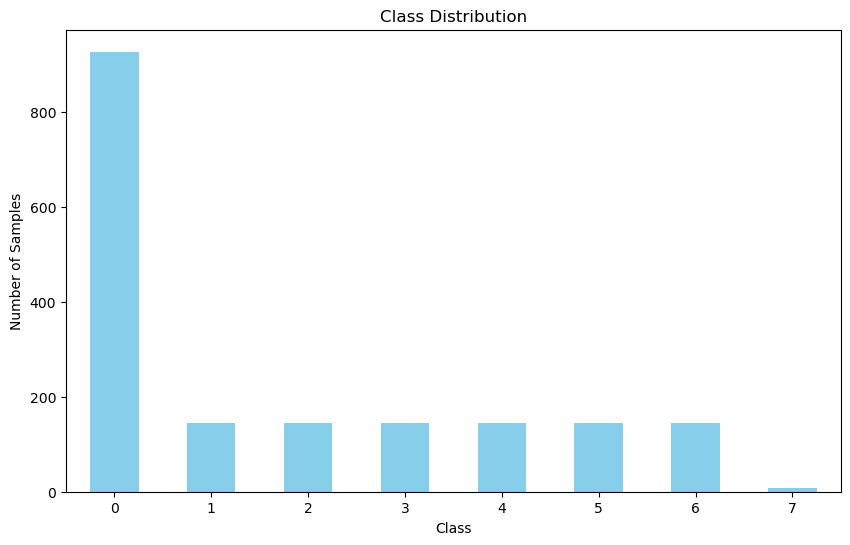

In [5]:
class_balances = features['gesture'].value_counts()
print(class_balances)
plt.figure(figsize=(10, 6))
class_balances.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

It shows that there are too few samples (8 samples) from class 7. We can give that class a higher weight in the loss functions of the future models but even training might not be good enough with this many samples. So we decided to remove the class 7 from the data.

Also, unmarked data belonging to class 0 dominates other classes in terms of number of samples and generally classifiers work better when all classes are balanced. So we can give it a lower weight or subsample the class 0. We chose to subsample the class.

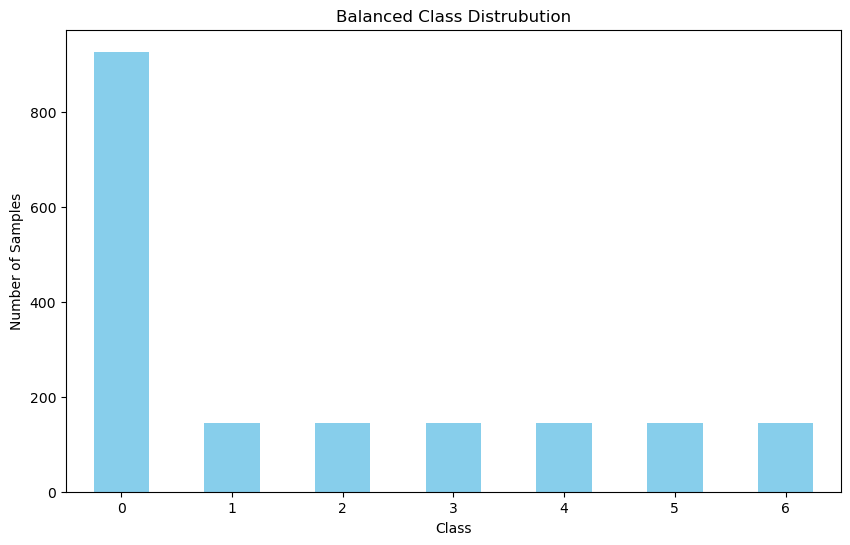

In [6]:
# Remove class 7 from the features dataframe
features_filtered = features[features['gesture'] != 7]

# Get the number of samples for the smallest class (excluding class 0)
min_class_count = features_filtered['gesture'].value_counts().min()

# Subsample class 0 to have the same number of samples as the smallest class
class_0_indices = features_filtered[features_filtered['gesture'] == 0].index
subsampled_class_0_indices = np.random.choice(class_0_indices, min_class_count, replace=False)

# Get the indices of all other classes
other_class_indices = features_filtered[features_filtered['gesture'] != 0].index

# Combine the subsampled class 0 indices with the other class indices
new_indices = np.concatenate([subsampled_class_0_indices, other_class_indices])

# Create the new features dataframe
features_balanced = features_filtered.loc[new_indices]

# Display the class distribution of the new features dataframe
plt.figure(figsize=(10, 6))
features_filtered['gesture'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distrubution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [7]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(features_filtered.drop(columns=['gesture']), features_filtered['gesture'], test_size=0.15, random_state=42)
# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
# Reset indices of the resulting datasets
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)



X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.30, random_state=42)
# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_validation shape: {X_validation.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_validation shape: {y_validation.shape}")
# Reset indices of the resulting datasets
X_train.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_validation.reset_index(drop=True, inplace=True)

X_train shape: (1521, 176)
X_test shape: (269, 176)
y_train shape: (1521,)
y_test shape: (269,)
X_train shape: (1064, 176)
X_validation shape: (457, 176)
y_train shape: (1064,)
y_validation shape: (457,)


In [8]:
# Initialize the StandardScaler
scaler = StandardScaler()

#Scale the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Only transform test set

# Convert scaled data back to DataFrame (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [9]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model using the scaled training data
logistic_model.fit(X_train_scaled, y_train)

# Print the training accuracy
train_accuracy = logistic_model.score(X_train_scaled, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

conf_matrix_lr, class_report_lr = test_model(logistic_model, X_test_scaled, y_test)


Training Accuracy: 0.9812
Confusion Matrix:
[[132   8   0   0   0   0   1]
 [  2  16   0   0   0   0   0]
 [  0   0  16   0   0   0   1]
 [  4   0   0  15   0   0   3]
 [  0   0   0   0  20   1   0]
 [  2   0   3   2   3  15   0]
 [  0   0   0   7   0   1  17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       141
           1       0.67      0.89      0.76        18
           2       0.84      0.94      0.89        17
           3       0.62      0.68      0.65        22
           4       0.87      0.95      0.91        21
           5       0.88      0.60      0.71        25
           6       0.77      0.68      0.72        25

    accuracy                           0.86       269
   macro avg       0.80      0.81      0.80       269
weighted avg       0.86      0.86      0.86       269



In [10]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(200, 200), max_iter=1000, random_state=42)

# Train the model using the scaled training data
mlp_model.fit(X_train_scaled, y_train)

# Print the training accuracy
train_accuracy_mlp = mlp_model.score(X_train_scaled, y_train)
print(f"Training Accuracy (MLP): {train_accuracy_mlp:.4f}")

conf_matrix_mlp, class_report_mlp = test_model(mlp_model, X_test_scaled, y_test)


#  K cluster
# SVM

#Ridge
#Lasso


Training Accuracy (MLP): 1.0000
Confusion Matrix:
[[133   7   0   0   0   0   1]
 [  1  17   0   0   0   0   0]
 [  0   0  16   0   0   0   1]
 [  0   0   1  20   0   0   1]
 [  0   0   0   0  21   0   0]
 [  4   0   3   0   2  16   0]
 [  0   0   0   6   0   0  19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       141
           1       0.71      0.94      0.81        18
           2       0.80      0.94      0.86        17
           3       0.77      0.91      0.83        22
           4       0.91      1.00      0.95        21
           5       1.00      0.64      0.78        25
           6       0.86      0.76      0.81        25

    accuracy                           0.90       269
   macro avg       0.86      0.88      0.86       269
weighted avg       0.91      0.90      0.90       269



In [11]:
""" import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming X_train_scaled is the data we are applying PCA on
# Step 1: Apply PCA to the training data and fit the model
pca = PCA(n_components=10)
pca.fit(X_train_scaled)  # You can apply to X_train, X_test, or the full dataset

# Step 2: Calculate explained variance and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 3: Plot the explained variance ratio and cumulative explained variance ratio
plt.figure(figsize=(8, 5))

# Plot the explained variance ratio for each component
plt.plot(range(1, 21), explained_variance_ratio, 'o-', label='Explained Variance Ratio', color='b')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance')
plt.xticks(range(1, 21))

# Plot the cumulative explained variance ratio
plt.plot(range(1, 21), cumulative_explained_variance, 'o-', label='Cumulative Explained Variance', color='r')
plt.legend()

plt.grid(True)
plt.show()

# Step 4: Now reduce dimensionality to 2 components for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)  # The data is now reduced to 2 dimensions

# Step 5: Plot the first two principal components
plt.figure(figsize=(8, 5))

# Assuming y_train is the label and we have classes 0 to 3 (adjust labels/colors as per your data)
plt.scatter(X_pca_2d[y_train == 0, 0], X_pca_2d[y_train == 0, 1], alpha=0.7, edgecolors='w', color='purple', s=50, label='Class 0')
plt.scatter(X_pca_2d[y_train == 1, 0], X_pca_2d[y_train == 1, 1], alpha=0.7, edgecolors='w', color='yellow', s=50, label='Class 1')
plt.scatter(X_pca_2d[y_train == 2, 0], X_pca_2d[y_train == 2, 1], alpha=0.7, edgecolors='w', color='black', s=50, label='Class 2')
plt.scatter(X_pca_2d[y_train == 3, 0], X_pca_2d[y_train == 3, 1], alpha=0.7, edgecolors='w', color='blue', s=50, label='Class 3')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First Two Principal Components of PCA')
plt.legend()
plt.show()
 """

" import matplotlib.pyplot as plt\nfrom sklearn.decomposition import PCA\n\n# Assuming X_train_scaled is the data we are applying PCA on\n# Step 1: Apply PCA to the training data and fit the model\npca = PCA(n_components=10)\npca.fit(X_train_scaled)  # You can apply to X_train, X_test, or the full dataset\n\n# Step 2: Calculate explained variance and cumulative variance\nexplained_variance_ratio = pca.explained_variance_ratio_\ncumulative_explained_variance = np.cumsum(explained_variance_ratio)\n\n# Step 3: Plot the explained variance ratio and cumulative explained variance ratio\nplt.figure(figsize=(8, 5))\n\n# Plot the explained variance ratio for each component\nplt.plot(range(1, 21), explained_variance_ratio, 'o-', label='Explained Variance Ratio', color='b')\nplt.xlabel('Principal Component')\nplt.ylabel('Explained Variance Ratio')\nplt.title('Explained Variance Ratio and Cumulative Explained Variance')\nplt.xticks(range(1, 21))\n\n# Plot the cumulative explained variance ratio\np

In [12]:
""" from sklearn.cluster import KMeans
from sklearn.svm import SVC


# Initialize the K-Means model
kmeans_model = KMeans(n_clusters=len(set(y_train)), random_state=42)  # Adjust n_clusters based on your dataset

# Fit the K-Means model using the training data
kmeans_model.fit(X_train_scaled)

# Predict cluster labels for training, test, and validation datasets
train_clusters = kmeans_model.predict(X_train_scaled)
test_clusters = kmeans_model.predict(X_test_scaled)
validation_clusters = kmeans_model.predict(X_validation_scaled)

# You can check inertia (within-cluster sum of squares) for evaluating K-Means
print(f"K-Means Inertia: {kmeans_model.inertia_:.4f}")

# Confusion matrix for K-Means (test set)
conf_matrix_kmeans_test = confusion_matrix(y_test, test_clusters)
print("\nK-Means Test Confusion Matrix:\n", conf_matrix_kmeans_test)

# Confusion matrix for K-Means (validation set)
conf_matrix_kmeans_validation = confusion_matrix(y_validation, validation_clusters)
print("\nK-Means Validation Confusion Matrix:\n", conf_matrix_kmeans_validation)

# Calculate the accuracy for K-Means clustering by comparing the clusters with true labels
accuracy_kmeans_test = accuracy_score(y_test, test_clusters)
accuracy_kmeans_validation = accuracy_score(y_validation, validation_clusters)

print(f"K-Means Test Accuracy: {accuracy_kmeans_test:.4f}")
print(f"K-Means Validation Accuracy: {accuracy_kmeans_validation:.4f}")

 """

' from sklearn.cluster import KMeans\nfrom sklearn.svm import SVC\n\n\n# Initialize the K-Means model\nkmeans_model = KMeans(n_clusters=len(set(y_train)), random_state=42)  # Adjust n_clusters based on your dataset\n\n# Fit the K-Means model using the training data\nkmeans_model.fit(X_train_scaled)\n\n# Predict cluster labels for training, test, and validation datasets\ntrain_clusters = kmeans_model.predict(X_train_scaled)\ntest_clusters = kmeans_model.predict(X_test_scaled)\nvalidation_clusters = kmeans_model.predict(X_validation_scaled)\n\n# You can check inertia (within-cluster sum of squares) for evaluating K-Means\nprint(f"K-Means Inertia: {kmeans_model.inertia_:.4f}")\n\n# Confusion matrix for K-Means (test set)\nconf_matrix_kmeans_test = confusion_matrix(y_test, test_clusters)\nprint("\nK-Means Test Confusion Matrix:\n", conf_matrix_kmeans_test)\n\n# Confusion matrix for K-Means (validation set)\nconf_matrix_kmeans_validation = confusion_matrix(y_validation, validation_clusters)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix, classification_report

# Initialize K-fold cross-validation (K=5 in this example)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'tol': [1e-2, 1e-3, 1e-4]
}

# Prepare to store results
results = []

for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for tol in param_grid['tol']:
            train_accuracies = []
            validation_accuracies = []
            validation_f1_scores = []
            
            # Perform K-Fold cross-validation
            for train_idx, val_idx in kf.split(X_train_scaled):
                # Split into K-Fold training and validation sets
                X_train_fold, X_val_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                # Train SVM with current hyperparameters
                svm_model = SVC(kernel=kernel, C=C, tol=tol, random_state=42)
                svm_model.fit(X_train_fold, y_train_fold)
                
                # Evaluate on both training and validation sets
                train_accuracy = svm_model.score(X_train_fold, y_train_fold)
                val_accuracy = svm_model.score(X_val_fold, y_val_fold)
                
                # Predict on validation set and compute F1 score
                val_predictions = svm_model.predict(X_val_fold)
                val_f1 = f1_score(y_val_fold, val_predictions, average='macro')
                
                # Store results for this fold
                train_accuracies.append(train_accuracy)
                validation_accuracies.append(val_accuracy)
                validation_f1_scores.append(val_f1)
            
            # Average scores across all folds
            avg_train_accuracy = np.mean(train_accuracies)
            avg_val_accuracy = np.mean(validation_accuracies)
            avg_val_f1_macro = np.mean(validation_f1_scores)
            
            # Store hyperparameters and results in a list
            results.append({
                'C': C,
                'kernel': kernel,
                'tol': tol,
                'avg_train_accuracy': avg_train_accuracy,
                'avg_val_accuracy': avg_val_accuracy,
                'avg_val_f1_macro': avg_val_f1_macro
            })

# Convert results to a DataFrame and find best parameters
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['avg_val_f1_macro'].idxmax()]

# Step 4: Retrain the best model on the entire training set
best_svm = SVC(kernel=best_params['kernel'], C=best_params['C'], tol=best_params['tol'], random_state=42)
best_svm.fit(X_train_scaled, y_train)

# Step 5: Evaluate the model on the test set (final evaluation)
test_accuracy = best_svm.score(X_test_scaled, y_test)
test_predictions = best_svm.predict(X_test_scaled)
test_f1_macro = f1_score(y_test, test_predictions, average='macro')

# Add test results to the DataFrame and save to CSV
results_df['test_accuracy'] = test_accuracy
results_df['test_f1_macro'] = test_f1_macro
results_df.to_csv('svm_kfold_results.csv', index=False)

print(f"Best Hyperparameters: {best_params}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")

Best Hyperparameters: C                         10.0
kernel                     rbf
tol                      0.001
avg_train_accuracy    0.986842
avg_val_accuracy      0.891908
avg_val_f1_macro      0.853796
Name: 43, dtype: object
Test Accuracy: 0.8736
Test F1 Macro: 0.8222


In [14]:

# Step 1: Apply PCA to reduce the dataset to 10 components
pca_10 = PCA(n_components=10)
X_train_pca = pca_10.fit_transform(X_train_scaled)  # Reduce training data
X_test_pca = pca_10.transform(X_test_scaled)        # Apply the same transformation to test data
X_validation_pca = pca_10.transform(X_validation_scaled)  # Apply transformation to validation data

# Step 2: Train the SVM model using the reduced dataset (10 PCA components)
svm_model_pca = SVC(kernel='linear', C=1, random_state=42)
svm_model_pca.fit(X_train_pca, y_train)

# Step 3: Train the K-Means Clustering model using the reduced dataset (10 PCA components)
kmeans_model_pca = KMeans(n_clusters=len(set(y_train)), random_state=42)  # Number of clusters = number of classes
kmeans_model_pca.fit(X_train_pca)

# Step 4: Evaluate the SVM model
# Accuracy on training, test, and validation sets
train_accuracy_pca = svm_model_pca.score(X_train_pca, y_train)
test_accuracy_pca = svm_model_pca.score(X_test_pca, y_test)
validation_accuracy_pca = svm_model_pca.score(X_validation_pca, y_validation)

print(f"SVM with PCA (10 components) Training Accuracy: {train_accuracy_pca:.4f}")
print(f"SVM with PCA (10 components) Test Accuracy: {test_accuracy_pca:.4f}")
print(f"SVM with PCA (10 components) Validation Accuracy: {validation_accuracy_pca:.4f}")

# Step 5: Generate confusion matrix and classification report for the SVM model on test and validation sets
test_predictions_pca = svm_model_pca.predict(X_test_pca)
conf_matrix_pca_test = confusion_matrix(y_test, test_predictions_pca)
class_report_pca_test = classification_report(y_test, test_predictions_pca)

print("\nSVM with PCA Test Confusion Matrix:\n", conf_matrix_pca_test)
print("\nSVM with PCA Test Classification Report:\n", class_report_pca_test)

validation_predictions_pca = svm_model_pca.predict(X_validation_pca)
conf_matrix_pca_validation = confusion_matrix(y_validation, validation_predictions_pca)
class_report_pca_validation = classification_report(y_validation, validation_predictions_pca)

print("\nSVM with PCA Validation Confusion Matrix:\n", conf_matrix_pca_validation)
print("\nSVM with PCA Validation Classification Report:\n", class_report_pca_validation)

# Step 6: Evaluate K-Means Clustering
# Predict clusters for the test and validation datasets
test_clusters_pca = kmeans_model_pca.predict(X_test_pca)
validation_clusters_pca = kmeans_model_pca.predict(X_validation_pca)

# Confusion matrix for K-Means (test set)
conf_matrix_kmeans_test = confusion_matrix(y_test, test_clusters_pca)
print("\nK-Means with PCA Test Confusion Matrix:\n", conf_matrix_kmeans_test)

# Confusion matrix for K-Means (validation set)
conf_matrix_kmeans_validation = confusion_matrix(y_validation, validation_clusters_pca)
print("\nK-Means with PCA Validation Confusion Matrix:\n", conf_matrix_kmeans_validation)

# Calculate the accuracy for K-Means clustering (by comparing clusters to labels)
accuracy_kmeans_test = accuracy_score(y_test, test_clusters_pca)
accuracy_kmeans_validation = accuracy_score(y_validation, validation_clusters_pca)

print(f"K-Means with PCA Test Accuracy: {accuracy_kmeans_test:.4f}")
print(f"K-Means with PCA Validation Accuracy: {accuracy_kmeans_validation:.4f}")

# Step 7: Plot the explained variance ratio and cumulative variance (optional)
explained_variance_ratio = pca_10.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), explained_variance_ratio, 'o-', label='Explained Variance Ratio', color='b')
plt.plot(range(1, 11), cumulative_explained_variance, 'o-', label='Cumulative Explained Variance', color='r')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance (10 Components)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'PCA' is not defined